In [1]:
from jaxdf import operators as jops
from jaxdf.core import operator, Field
from jaxdf.discretization import FourierSeries, Coordinate
from jaxdf.geometry import Domain
from jaxdf.utils import join_dicts
from jax import numpy as jnp
from jax.scipy.sparse.linalg import gmres
from jax.example_libraries import optimizers
import jax

# Settings
domain = Domain((256, 256), (1., 1.))
seed = jax.random.PRNGKey(42)

# Speed of sound parametrization
lens_params = jax.random.uniform(seed, (168,40)) - 4
def get_sos(p):
    lens = jnp.zeros(domain.N).at[44:212,108:148].set(jax.nn.sigmoid(p)) + 1
    return jnp.expand_dims(lens, -1)

# Defining operators
@jops.elementwise
def pml_absorption(x):
    abs_x = jnp.abs(x)
    return jnp.where(abs_x > 110, (jnp.abs(abs_x-110)/(128. - 110)), 0.)**2

gamma = lambda x: 1./(1 + 1j*pml_absorption(x))

@operator()
def helmholtz(u, c, x):
    pml = gamma(x)
    mod_grad_u = jops.gradient(u)*pml
    mod_diag_jacobian = jops.diag_jacobian(mod_grad_u)*pml
    laplacian = jops.sum_over_dims(mod_diag_jacobian)
    return laplacian + ((1./c)**2)*u

@operator()
def integrand_TV(u):
    nabla_u = jops.gradient(u)    
    return jops.sum_over_dims(jops.elementwise(jnp.abs)(nabla_u))

# Defining discretizations
fourier_discr = FourierSeries(domain)
u_fourier_params, u = fourier_discr.empty_field(name='u')
src_fourier_params, src = fourier_discr.empty_field(name='src')
src_fourier_params = u_fourier_params.at[128, 40].set(1. + 0j)  # Monopole source
_, c = fourier_discr.empty_field(name='c')
_, x = fourier_discr.empty_field(name='x')
x_params = Coordinate(domain).get_field_on_grid()({}) # Coordinate field

# Discretizing operators: getting pure functions and parameters
H = helmholtz(u=u, c=c, x=x)
TV = integrand_TV(u=u)
global_params = join_dicts(H.get_global_params(), TV.get_global_params())
H_on_grid = H.get_field_on_grid(0)
tv_on_grid = lambda x: TV.get_field_on_grid(0)(global_params, {"u": x})

# Helmholtz solver function
def solve_helmholtz(speed_of_sound):
    params = {"c":speed_of_sound, "x":x_params}
    def helm_func(u):
        params["u"] = u
        return H_on_grid(global_params, params)
    sol, _ = gmres(helm_func, src_fourier_params, maxiter=1000, tol=1e-3, restart=50)
    return sol

# Loss function
def loss(p):
    sos = get_sos(p)
    tv_term = jnp.mean(tv_on_grid(sos))
    field = solve_helmholtz(sos)
    return -jnp.sum(jnp.abs(field[70,210])) + 1e-4*tv_term

# Optimization loop
init_fun, update_fun, get_params = optimizers.adam(.1, b1=0.9, b2=0.9)
opt_state = init_fun(lens_params)

@jax.jit
def update(opt_state, k):
    lossval, gradient = jax.value_and_grad(loss)(get_params(opt_state))
    return lossval, update_fun(k, gradient, opt_state)

for k in range(100):
    lossval, opt_state = update(opt_state, k)
    print(f"Step {k}, Loss {lossval}")

Step 0, Loss -0.014219305478036404
Step 1, Loss -0.023069269955158234
Step 2, Loss -0.03171045333147049
Step 3, Loss -0.040071554481983185
Step 4, Loss -0.04820648953318596
Step 5, Loss -0.056011103093624115
Step 6, Loss -0.06344794481992722
Step 7, Loss -0.07043972611427307
Step 8, Loss -0.07690691947937012
Step 9, Loss -0.08277024328708649
Step 10, Loss -0.087948739528656
Step 11, Loss -0.09237437695264816
Step 12, Loss -0.09599694609642029
Step 13, Loss -0.09880382567644119
Step 14, Loss -0.10088269412517548
Step 15, Loss -0.10230313986539841
Step 16, Loss -0.10329990088939667
Step 17, Loss -0.104139044880867
Step 18, Loss -0.1050543561577797
Step 19, Loss -0.10620315372943878
Step 20, Loss -0.1076010912656784
Step 21, Loss -0.10916072875261307
Step 22, Loss -0.11074436455965042
Step 23, Loss -0.11221525818109512
Step 24, Loss -0.11343951523303986
Step 25, Loss -0.11436954140663147
Step 26, Loss -0.11499220132827759
Step 27, Loss -0.115354984998703
Step 28, Loss -0.11556363850831985

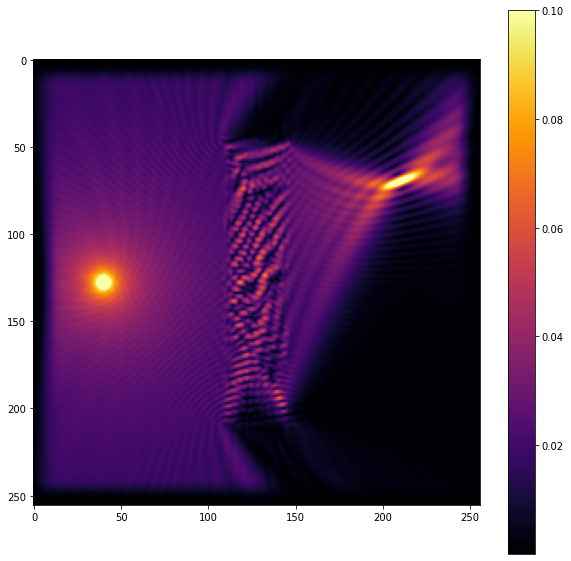

In [4]:
from matplotlib import pyplot as plt

optimal_field = solve_helmholtz(get_sos(get_params(opt_state)))
plt.figure(figsize=(10,10))
plt.imshow(jnp.abs(optimal_field), cmap="inferno", vmax=.1)
plt.colorbar()